# IoT Water Quality Monitoring + ML Decision Support (Shrimp Farming)

This notebook trains a multi-class ML model using `WQD.xlsx` (sheet `Final_Data`) to predict **Water Quality** classes (0/1/2) from water parameters.

It also demonstrates a **rule-based threshold checker** + **ML prediction** to recommend actions (e.g., partial or immediate water exchange).

**Outputs:**
- `water_quality_model.joblib`
- `model_metadata.json`


In [19]:
# If running in Colab, uncomment:
# from google.colab import files
# uploaded = files.upload()  # Upload WQD_synthetic_35000.csv

import os

# Silence the loky warning about physical cores on Windows
os.environ["LOKY_MAX_CPU_COUNT"] = str(os.cpu_count())

import json
import joblib
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

In [20]:
# -----------------------------
# 1) Load dataset (CSV version - 35000 samples)
# -----------------------------
DATA_PATH = "WQD_synthetic_35000.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Could not find {DATA_PATH}. Put the CSV file in the same folder as this notebook, or update DATA_PATH."
    )

df = pd.read_csv(DATA_PATH)
print(f"Dataset: {DATA_PATH}")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
display(df.head(10))

Dataset: WQD_synthetic_35000.csv
Shape: 35,000 rows × 15 columns


,Temp,Turbidity (cm),DO(mg/L),BOD (mg/L),CO2,pH`,Alkalinity (mg L-1 ),Hardness (mg L-1 ),Calcium (mg L-1 ),Ammonia (mg L-1 ),Nitrite (mg L-1 ),Phosphorus (mg L-1 ),H2S (mg L-1 ),Plankton (No. L-1),Water Quality
0,29.227103,61.713178,3.594848,1.032362,7.976345,7.566291,75.292575,87.007520,33.997688,0.022152,0.007450,0.513808,0.019601,3742.451752,0
1,28.482818,67.537688,3.503741,1.769808,6.308790,7.257483,78.051200,141.064537,74.902467,0.023868,0.016039,1.901014,0.019398,3038.875971,0
2,34.013403,29.023695,6.604400,3.620926,2.591148,9.178917,29.985275,38.630780,115.615775,0.028983,0.671165,2.237975,0.018864,2853.550808,1
3,18.203761,17.951065,7.358075,3.735434,1.912308,6.386141,38.296150,178.742661,196.769854,0.049802,0.473423,2.101557,0.001494,2169.794658,1
4,26.124441,66.256173,4.808418,1.414935,6.671474,8.229495,49.171578,146.521790,51.854246,0.012241,0.019290,0.128071,0.019526,3359.172779,0
5,31.367889,79.334274,3.535593,1.851244,6.642027,8.002358,32.420046,233.734674,138.839530,0.010302,0.006976,2.421717,0.019154,4129.171435,2
6,34.553812,19.801316,7.097791,5.511284,9.857241,9.097981,25.538714,154.024427,227.697011,0.046020,0.471773,2.137936,0.016511,2639.410862,1
7,24.692730,33.175357,7.426887,1.355310,5.737909,6.250308,81.417604,156.132918,17.017713,0.002702,0.788881,0.029772,0.010758,2748.916444,2
8,30.168533,26.032300,5.628481,4.652561,1.995154,6.252049,35.698274,37.623958,20.688903,0.027145,0.344803,0.025261,0.013477,4753.877582,1
9,15.883269,17.538254,5.307947,4.644711,1.925654,9.108870,141.637880,52.561824,109.533843,0.037944,0.732372,0.029598,0.016554,5704.586616,1


In [21]:
# -----------------------------
# 2) Clean column names
# -----------------------------
df = df.copy()

# Example: 'pH`' -> 'pH'
df.rename(columns={"pH`": "pH"}, inplace=True)

# Strip extra spaces
df.columns = [c.strip() for c in df.columns]

target_col = "Water Quality"
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found. Available columns: {list(df.columns)}")

print("Columns:")
for c in df.columns:
    print("-", c)


Columns:
- Temp
- Turbidity (cm)
- DO(mg/L)
- BOD (mg/L)
- CO2
- pH
- Alkalinity (mg L-1 )
- Hardness (mg L-1 )
- Calcium (mg L-1 )
- Ammonia (mg L-1 )
- Nitrite (mg L-1 )
- Phosphorus (mg L-1 )
- H2S (mg L-1 )
- Plankton (No. L-1)
- Water Quality


## Quick EDA (Exploratory Data Analysis)
- Dataset overview and statistics
- Class distribution
- Feature distributions
- Correlation analysis
- Missing values check

In [22]:
# -----------------------------
# Dataset Overview
# -----------------------------
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)

# Basic info
print(f"\n📊 Total Samples: {len(df):,}")
print(f"📋 Total Features: {len(df.columns) - 1}")
print(f"🎯 Target Column: Water Quality")

# Missing values
missing = df.isnull().sum()
print(f"\n❌ Missing Values: {missing.sum()}")
if missing.sum() > 0:
    print(missing[missing > 0])

# Data types
print("\n📝 Data Types:")
display(df.dtypes)

# Statistical summary
print("\n📈 Statistical Summary:")
display(df.describe().T.style.background_gradient(cmap='Blues'))

DATASET OVERVIEW

📊 Total Samples: 35,000
📋 Total Features: 14
🎯 Target Column: Water Quality

❌ Missing Values: 0

📝 Data Types:


Temp                    float64
Turbidity (cm)          float64
DO(mg/L)                float64
BOD (mg/L)              float64
CO2                     float64
pH                      float64
Alkalinity (mg L-1 )    float64
Hardness (mg L-1 )      float64
Calcium (mg L-1 )       float64
Ammonia (mg L-1 )       float64
Nitrite (mg L-1 )       float64
Phosphorus (mg L-1 )    float64
H2S (mg L-1 )           float64
Plankton (No. L-1)      float64
Water Quality             int64
dtype: object


📈 Statistical Summary:


,count,mean,std,min,25%,50%,75%,max
Temp,35000.000000,25.692318,9.683776,0.194046,19.767504,24.988090,30.246431,84.251522
Turbidity (cm),35000.000000,39.052478,20.906412,0.051424,22.298204,30.444442,55.781976,99.797743
DO(mg/L),35000.000000,5.294741,1.820499,0.133928,3.970318,4.998787,6.538857,14.970122
BOD (mg/L),35000.000000,3.110343,2.284818,1.000629,1.517109,2.221739,4.305606,14.943006
CO2,35000.000000,6.380074,2.837309,0.001733,5.081143,6.578520,8.245381,14.984216
pH,35000.000000,7.709670,1.563551,0.003944,6.443642,7.734040,9.040856,14.851195
Alkalinity (mg L-1 ),35000.000000,93.407491,68.780099,25.012542,40.396486,66.989693,132.212715,299.808269
Hardness (mg L-1 ),35000.000000,126.656716,79.251238,0.255805,68.734787,110.490141,161.160544,398.796550
Calcium (mg L-1 ),35000.000000,85.147774,75.830168,0.018293,23.739947,62.747841,117.090758,399.321398
Ammonia (mg L-1 ),35000.000000,0.047899,0.121219,0.000003,0.012930,0.026416,0.039007,0.999300


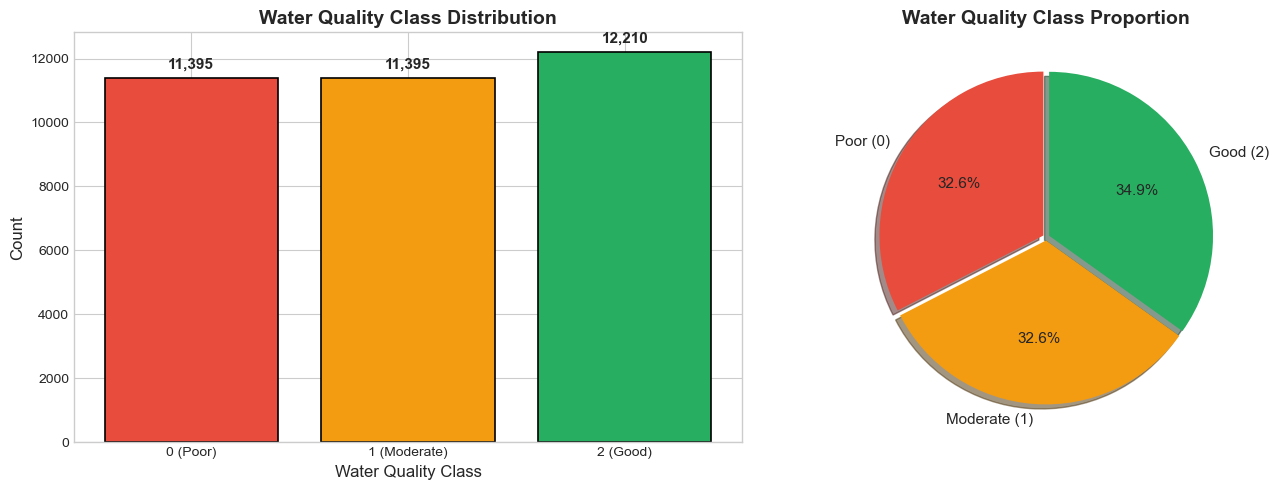


📊 Class Balance:
   Class 0: 11,395 samples (32.6%)
   Class 1: 11,395 samples (32.6%)
   Class 2: 12,210 samples (34.9%)


In [23]:
# -----------------------------
# Class Distribution Visualization
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
class_counts = df[target_col].value_counts().sort_index()
colors = ['#e74c3c', '#f39c12', '#27ae60']  # Red, Orange, Green for Poor, Moderate, Good
bars = axes[0].bar(class_counts.index, class_counts.values, color=colors, edgecolor='black', linewidth=1.2)
axes[0].set_xlabel('Water Quality Class', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Water Quality Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(['0 (Poor)', '1 (Moderate)', '2 (Good)'])

# Add count labels on bars
for bar, count in zip(bars, class_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200, 
                 f'{count:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pie chart
axes[1].pie(class_counts.values, labels=['Poor (0)', 'Moderate (1)', 'Good (2)'], 
            colors=colors, autopct='%1.1f%%', startangle=90, 
            explode=(0.02, 0.02, 0.02), shadow=True,
            textprops={'fontsize': 11})
axes[1].set_title('Water Quality Class Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Class Balance:")
for cls, count in class_counts.items():
    pct = count / len(df) * 100
    print(f"   Class {cls}: {count:,} samples ({pct:.1f}%)")

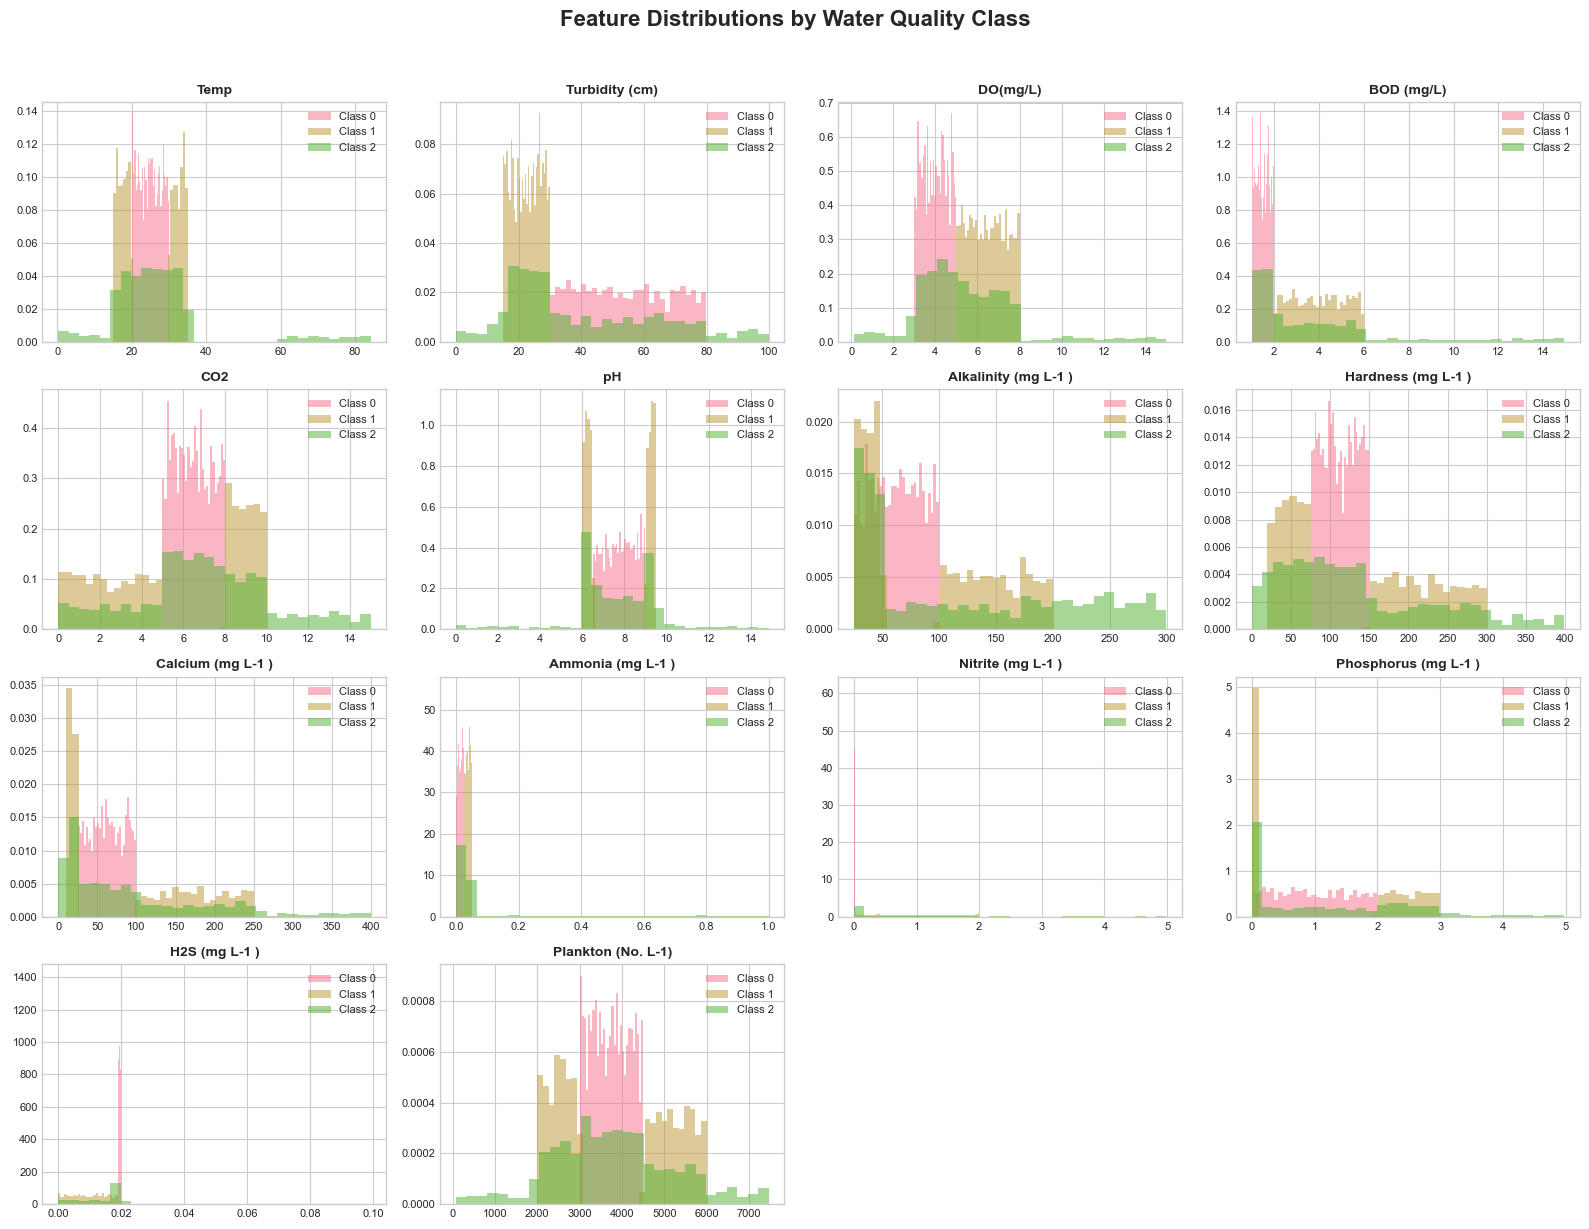

In [24]:
# -----------------------------
# Feature Distributions by Water Quality Class
# -----------------------------
feature_cols = [c for c in df.columns if c != target_col]
n_features = len(feature_cols)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    for cls in sorted(df[target_col].unique()):
        subset = df[df[target_col] == cls][col]
        axes[i].hist(subset, bins=30, alpha=0.5, label=f'Class {cls}', density=True)
    axes[i].set_title(col, fontsize=10, fontweight='bold')
    axes[i].legend(fontsize=8)
    axes[i].tick_params(labelsize=8)

# Hide empty subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Feature Distributions by Water Quality Class', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

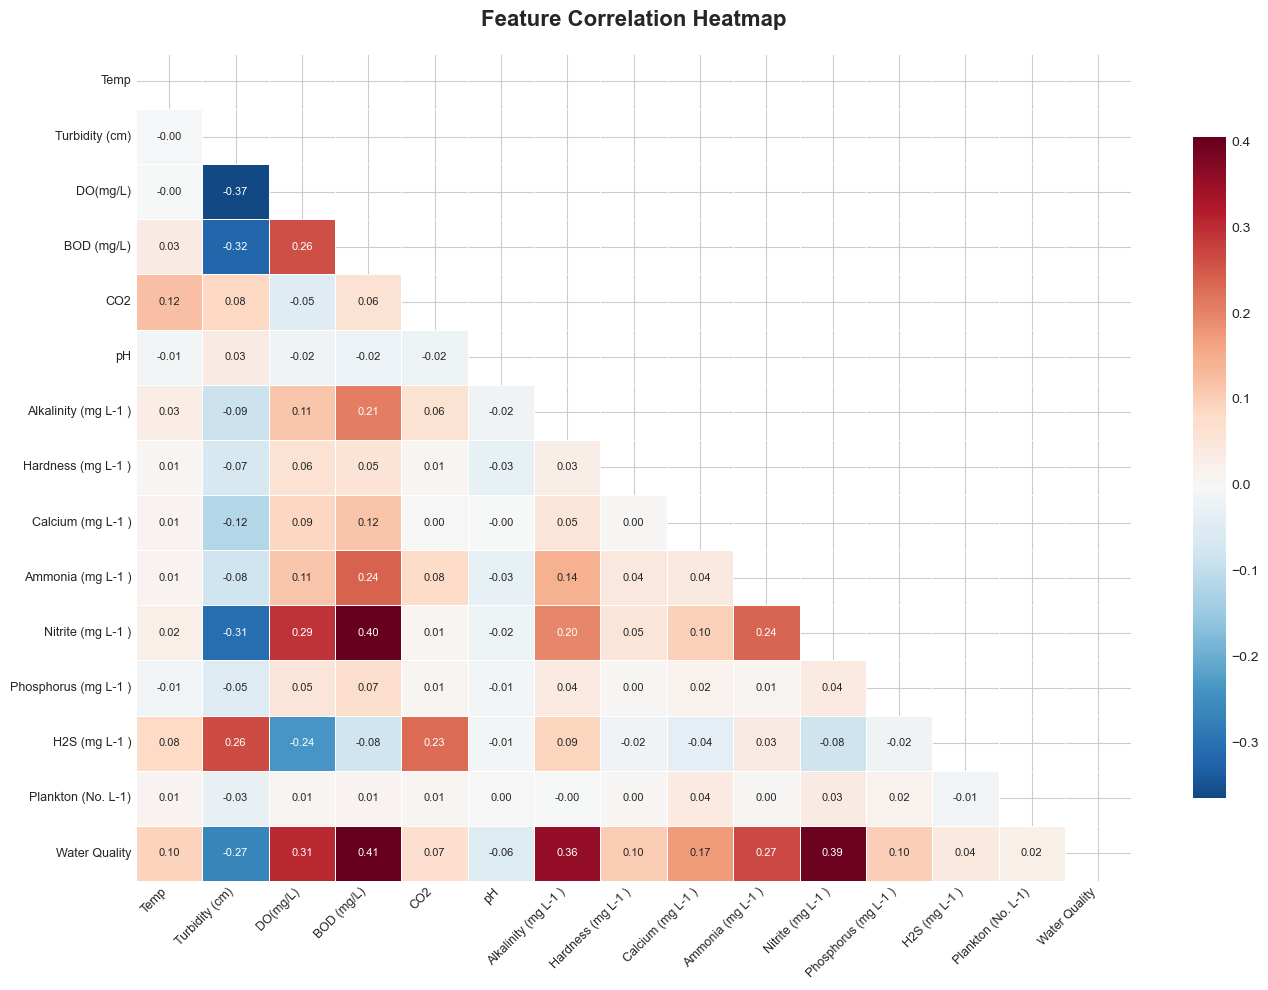


🔗 Top Feature Correlations with Water Quality:
   BOD (mg/L): 0.406
   Nitrite (mg L-1 ): 0.394
   Alkalinity (mg L-1 ): 0.356
   DO(mg/L): 0.306
   Ammonia (mg L-1 ): 0.266
   Turbidity (cm): 0.266
   Calcium (mg L-1 ): 0.171


In [25]:
# -----------------------------
# Correlation Heatmap
# -----------------------------
plt.figure(figsize=(14, 10))
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, linewidths=0.5, annot_kws={'size': 8},
            cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

# Show top correlations with target
print("\n🔗 Top Feature Correlations with Water Quality:")
target_corr = corr_matrix[target_col].drop(target_col).abs().sort_values(ascending=False)
for feat, corr in target_corr.head(7).items():
    print(f"   {feat}: {corr:.3f}")

C:\Users\dilan\AppData\Local\Temp\ipykernel_12388\1812550778.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=param, data=df, ax=axes[i], palette=colors)
C:\Users\dilan\AppData\Local\Temp\ipykernel_12388\1812550778.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=param, data=df, ax=axes[i], palette=colors)
C:\Users\dilan\AppData\Local\Temp\ipykernel_12388\1812550778.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=param, data=df, ax=axes[i], palette=colors)
C:\Users\dilan\AppData\Lo

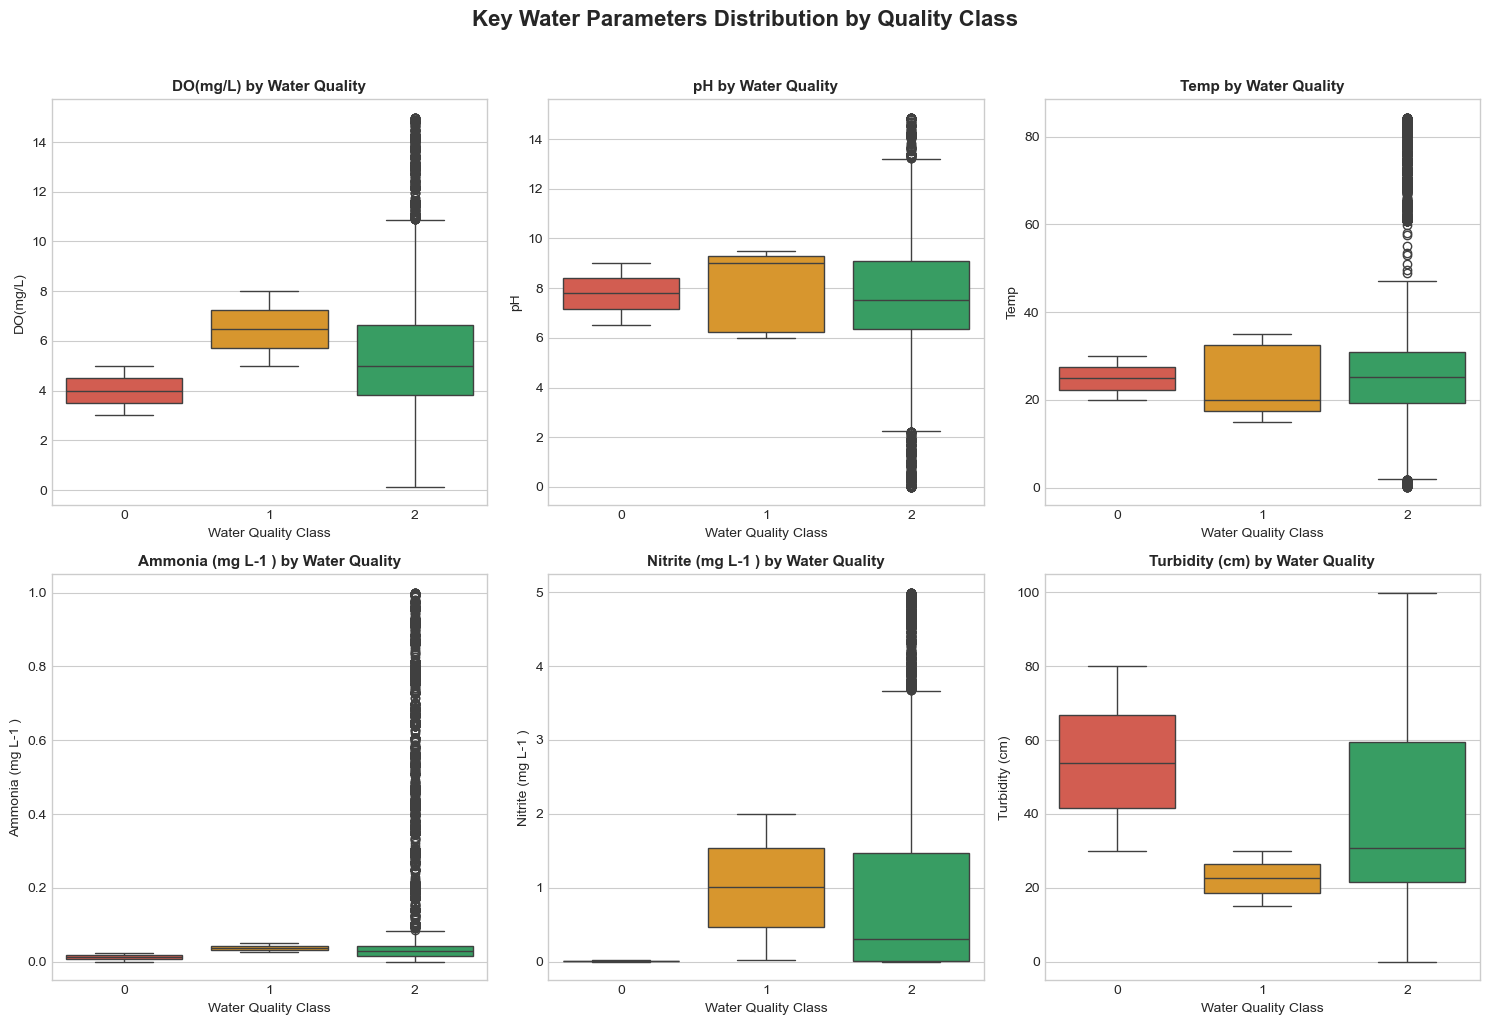

In [26]:
# -----------------------------
# Box Plots for Key Water Quality Parameters
# -----------------------------
key_params = ['DO(mg/L)', 'pH', 'Temp', 'Ammonia (mg L-1 )', 'Nitrite (mg L-1 )', 'Turbidity (cm)']
available_params = [p for p in key_params if p in df.columns]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, param in enumerate(available_params):
    sns.boxplot(x=target_col, y=param, data=df, ax=axes[i], palette=colors)
    axes[i].set_title(f'{param} by Water Quality', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Water Quality Class')
    
plt.suptitle('Key Water Parameters Distribution by Quality Class', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 3) Train/Test Split + Model Training

We train a **multi-class classifier**. Two strong baselines are:
- `RandomForestClassifier`
- `HistGradientBoostingClassifier`

We pick the best model by **macro F1** (good for balanced multi-class).

In [27]:
# -----------------------------
# 3) Train/Test Split + Model Training
# -----------------------------
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 Training set: {len(X_train):,} samples")
print(f"📊 Test set: {len(X_test):,} samples")

# Define candidate models
candidates = {
    "RandomForest": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", RandomForestClassifier(
            n_estimators=400,
            max_depth=20,
            random_state=42,
            n_jobs=-1
        ))
    ]),
    "HistGradientBoosting": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", HistGradientBoostingClassifier(
            max_iter=200,
            random_state=42
        ))
    ])
}

# Train and evaluate all models
results = []
best_name, best_pipe, best_f1 = None, None, -1

print("\n🚀 Training models...")
for name, pipe in candidates.items():
    print(f"   Training {name}...", end=" ")
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, average="macro")
    results.append({"Model": name, "Accuracy": acc, "Macro F1": f1})
    print(f"Done! (Accuracy: {acc:.4f}, F1: {f1:.4f})")
    if f1 > best_f1:
        best_name, best_pipe, best_f1 = name, pipe, f1

results_df = pd.DataFrame(results).sort_values("Macro F1", ascending=False)
print("\n" + "=" * 60)
print("MODEL COMPARISON RESULTS")
print("=" * 60)
display(results_df.style.highlight_max(subset=["Accuracy", "Macro F1"], color='lightgreen'))

print(f"\n✅ Selected Best Model: {best_name} (Macro F1: {best_f1:.4f})")

📊 Training set: 28,000 samples
📊 Test set: 7,000 samples

🚀 Training models...
   Training RandomForest... Done! (Accuracy: 0.9991, F1: 0.9992)
   Training HistGradientBoosting... Done! (Accuracy: 0.9991, F1: 0.9992)

MODEL COMPARISON RESULTS


,Model,Accuracy,Macro F1
0,RandomForest,0.999143,0.999152
1,HistGradientBoosting,0.999143,0.999152



✅ Selected Best Model: RandomForest (Macro F1: 0.9992)


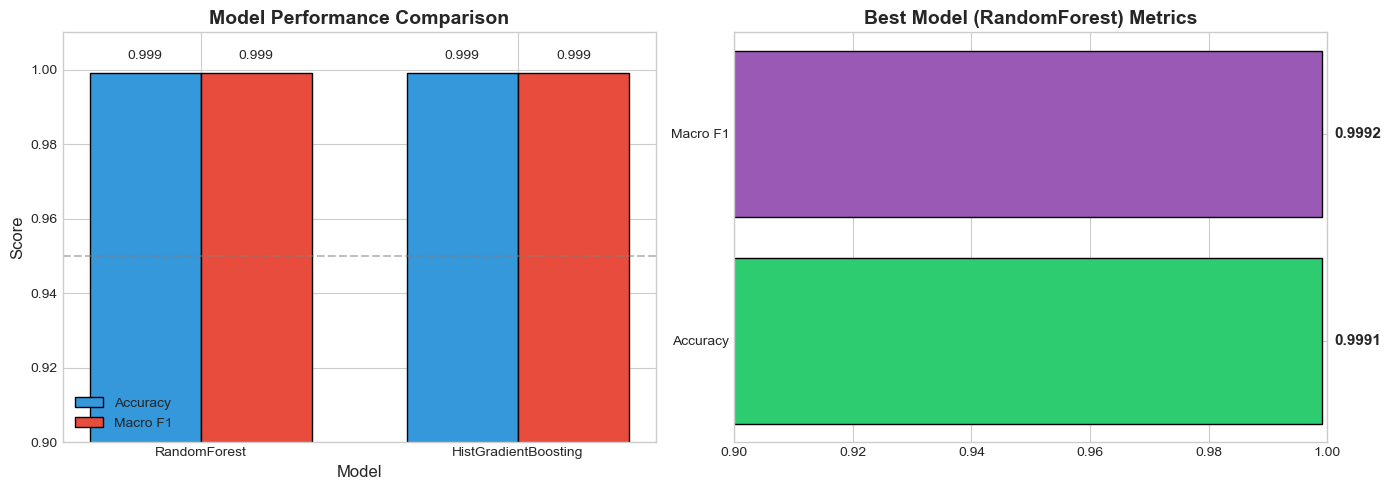

In [28]:
# -----------------------------
# Model Accuracy Comparison Chart
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart comparison
x_pos = np.arange(len(results_df))
width = 0.35

bars1 = axes[0].bar(x_pos - width/2, results_df['Accuracy'], width, label='Accuracy', color='#3498db', edgecolor='black')
bars2 = axes[0].bar(x_pos + width/2, results_df['Macro F1'], width, label='Macro F1', color='#e74c3c', edgecolor='black')

axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(results_df['Model'])
axes[0].legend()
axes[0].set_ylim(0.9, 1.01)
axes[0].axhline(y=0.95, color='gray', linestyle='--', alpha=0.5, label='95% baseline')

# Add value labels
for bar in bars1:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003, 
                 f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=10)
for bar in bars2:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003, 
                 f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=10)

# Radar/spider chart for multi-metric comparison (simplified as grouped bar)
metrics = ['Accuracy', 'Macro F1']
axes[1].barh(metrics, [results_df[results_df['Model']==best_name]['Accuracy'].values[0],
                       results_df[results_df['Model']==best_name]['Macro F1'].values[0]], 
             color=['#2ecc71', '#9b59b6'], edgecolor='black')
axes[1].set_xlim(0.9, 1.0)
axes[1].set_title(f'Best Model ({best_name}) Metrics', fontsize=14, fontweight='bold')
for i, v in enumerate([results_df[results_df['Model']==best_name]['Accuracy'].values[0],
                       results_df[results_df['Model']==best_name]['Macro F1'].values[0]]):
    axes[1].text(v + 0.002, i, f'{v:.4f}', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

CLASSIFICATION REPORT - RandomForest
              precision    recall  f1-score   support

    Poor (0)       1.00      1.00      1.00      2279
Moderate (1)       1.00      1.00      1.00      2279
    Good (2)       1.00      1.00      1.00      2442

    accuracy                           1.00      7000
   macro avg       1.00      1.00      1.00      7000
weighted avg       1.00      1.00      1.00      7000



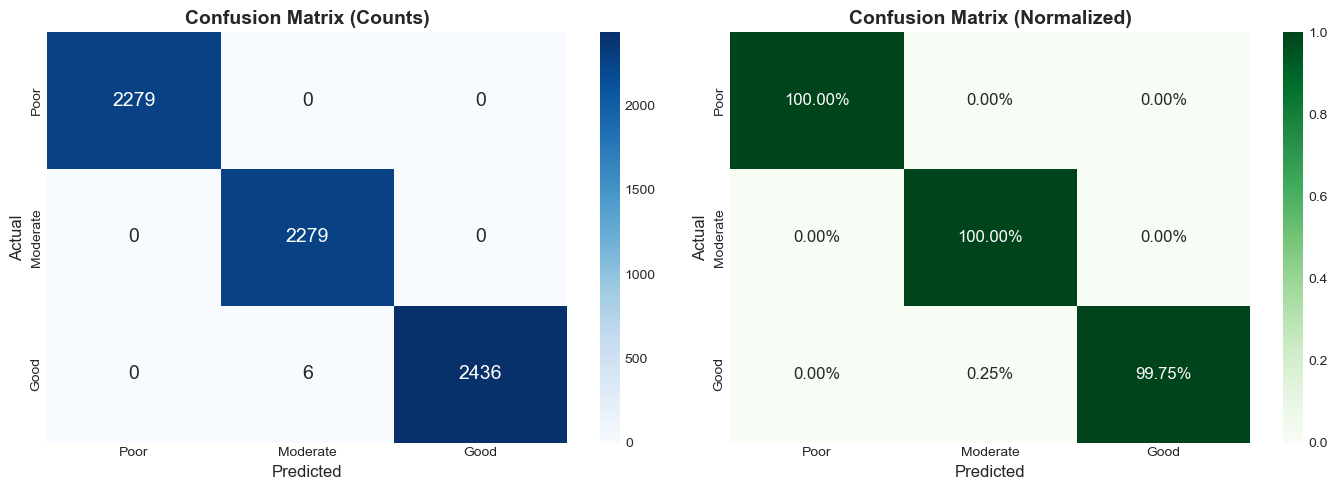


📊 Per-Class Accuracy:
   Poor (0): 100.00%
   Moderate (1): 100.00%
   Good (2): 99.75%


In [29]:
# -----------------------------
# Detailed Model Evaluation
# -----------------------------
pred = best_pipe.predict(X_test)

print("=" * 60)
print(f"CLASSIFICATION REPORT - {best_name}")
print("=" * 60)
print(classification_report(y_test, pred, target_names=['Poor (0)', 'Moderate (1)', 'Good (2)']))

# Confusion Matrix Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap confusion matrix
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Poor', 'Moderate', 'Good'],
            yticklabels=['Poor', 'Moderate', 'Good'],
            annot_kws={'size': 14})
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

# Normalized confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=['Poor', 'Moderate', 'Good'],
            yticklabels=['Poor', 'Moderate', 'Good'],
            annot_kws={'size': 12})
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Per-class accuracy
print("\n📊 Per-Class Accuracy:")
for i, cls in enumerate(['Poor (0)', 'Moderate (1)', 'Good (2)']):
    class_acc = cm[i, i] / cm[i, :].sum()
    print(f"   {cls}: {class_acc:.2%}")

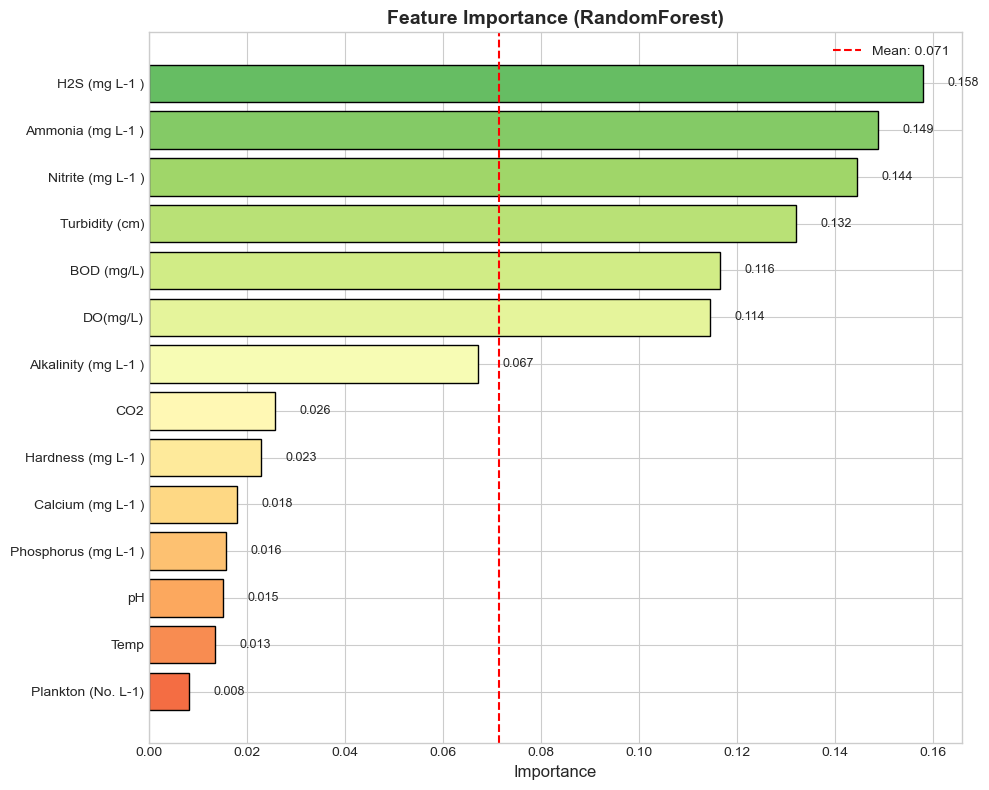


🔝 Top 5 Most Important Features:
   H2S (mg L-1 ): 0.1579
   Ammonia (mg L-1 ): 0.1487
   Nitrite (mg L-1 ): 0.1444
   Turbidity (cm): 0.1320
   BOD (mg/L): 0.1165


In [30]:
# -----------------------------
# Feature Importance Analysis
# -----------------------------
if hasattr(best_pipe.named_steps['model'], 'feature_importances_'):
    importances = best_pipe.named_steps['model'].feature_importances_
    feature_names = X.columns
    
    # Create dataframe and sort
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=True)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(importance_df)))
    bars = ax.barh(importance_df['Feature'], importance_df['Importance'], color=colors, edgecolor='black')
    
    ax.set_xlabel('Importance', fontsize=12)
    ax.set_title(f'Feature Importance ({best_name})', fontsize=14, fontweight='bold')
    ax.axvline(x=importance_df['Importance'].mean(), color='red', linestyle='--', 
               label=f'Mean: {importance_df["Importance"].mean():.3f}')
    ax.legend()
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print("\n🔝 Top 5 Most Important Features:")
    for _, row in importance_df.tail(5).iloc[::-1].iterrows():
        print(f"   {row['Feature']}: {row['Importance']:.4f}")

## 4) Export the trained model

This saves:
- `water_quality_model.joblib` (pipeline including preprocessing)
- `model_metadata.json` (feature list, classes, etc.)


In [31]:
# -----------------------------
# 4) Export the trained model
# -----------------------------
MODEL_PATH = "water_quality_model.joblib"
META_PATH = "model_metadata.json"

joblib.dump(best_pipe, MODEL_PATH)

metadata = {
    "model_name": best_name,
    "features": list(X.columns),
    "target": target_col,
    "classes": sorted(y.unique().tolist()),
    "class_labels": {0: "Poor", 1: "Moderate", 2: "Good"},
    "dataset": DATA_PATH,
    "dataset_size": len(df),
    "test_accuracy": float(accuracy_score(y_test, pred)),
    "test_f1_macro": float(best_f1),
    "note": "Trained on synthetic 35K dataset. Map class IDs to labels using class_labels."
}
with open(META_PATH, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)

print("=" * 60)
print("MODEL EXPORT COMPLETE")
print("=" * 60)
print(f"\n✅ Model saved: {MODEL_PATH}")
print(f"✅ Metadata saved: {META_PATH}")
print(f"\n📊 Model Performance Summary:")
print(f"   - Accuracy: {metadata['test_accuracy']:.4f}")
print(f"   - Macro F1: {metadata['test_f1_macro']:.4f}")
print(f"   - Dataset: {metadata['dataset_size']:,} samples")

MODEL EXPORT COMPLETE

✅ Model saved: water_quality_model.joblib
✅ Metadata saved: model_metadata.json

📊 Model Performance Summary:
   - Accuracy: 0.9991
   - Macro F1: 0.9992
   - Dataset: 35,000 samples


## 5) Threshold Rules (Editable) + Decision Support

Below are **default** thresholds you can edit for your shrimp species and management plan.

Typical ranges commonly cited in shrimp pond guidance include:
- pH around **7.5–8.5**
- DO ideally **≥4–5 mg/L**
- Temperature often **~25–30°C** or **~28–33°C** depending on the guideline
- Turbidity/visibility (Secchi) often around **~25–45 cm**

You should adapt these ranges to Sri Lankan farm conditions, stocking density, and species.


In [32]:
# Threshold format: (warn_low, warn_high, crit_low, crit_high)
# Use None if a side is not applicable.

THRESHOLDS = {
    "DO(mg/L)":            (5.0, None, 4.0, None),   # warn <5, critical <4
    "pH":                 (7.5, 8.5, 7.0, 9.0),     # warn outside 7.5-8.5, critical outside 7-9
    "Temp":               (25.0, 32.0, 20.0, 34.0), # editable (guidelines vary)
    "Turbidity (cm)":     (25.0, 45.0, 15.0, 60.0),
    "Ammonia (mg L-1 )":  (None, 0.5, None, 1.0),  # warn >0.5, critical >1.0
    "Nitrite (mg L-1 )":  (None, 0.3, None, 0.4),
    "H2S (mg L-1 )":      (None, 0.005, None, 0.01) # mg/L (0.005 mg/L = 5 µg/L)
}

def check_thresholds(reading: dict, thresholds=THRESHOLDS):
    """Return per-parameter status: OK / WARNING / CRITICAL."""
    report = {}
    for param, (w_lo, w_hi, c_lo, c_hi) in thresholds.items():
        if param not in reading:
            continue
        v = reading[param]
        status = "OK"
        # Critical checks first
        if c_lo is not None and v < c_lo:
            status = "CRITICAL"
        if c_hi is not None and v > c_hi:
            status = "CRITICAL"
        # Warning checks
        if status != "CRITICAL":
            if w_lo is not None and v < w_lo:
                status = "WARNING"
            if w_hi is not None and v > w_hi:
                status = "WARNING"
        report[param] = {"value": float(v), "status": status}
    return report

def recommend_action(reading: dict, model_pipe):
    """Combine threshold rules + ML prediction for an action recommendation."""
    thr = check_thresholds(reading)
    statuses = [x["status"] for x in thr.values()] if thr else []

    # ML prediction
    X_one = pd.DataFrame([reading])
    # Ensure required columns exist
    for col in metadata["features"]:
        if col not in X_one.columns:
            X_one[col] = np.nan
    X_one = X_one[metadata["features"]]

    pred_class = int(model_pipe.predict(X_one)[0])

    # Simple decision policy (EDIT THIS!)
    if "CRITICAL" in statuses:
        action = "IMMEDIATE ACTION: increase aeration + consider immediate partial/major water exchange"
    elif "WARNING" in statuses:
        action = "WARNING: monitor closely + consider partial water exchange"
    else:
        action = "OK: no urgent water exchange needed (continue monitoring)"

    return {
        "ml_predicted_class": pred_class,
        "threshold_report": thr,
        "recommended_action": action
    }


In [33]:
# -----------------------------
# 6) Example: simulate an IoT sensor reading (ESP32 JSON payload)
# -----------------------------
example_reading = {
    "Temp": 29.5,
    "Turbidity (cm)": 35.0,
    "DO(mg/L)": 4.2,
    "BOD (mg/L)": 3.0,
    "CO2": 6.0,
    "pH": 7.4,
    "Alkalinity (mg L-1 )": 120.0,
    "Hardness (mg L-1 )": 130.0,
    "Calcium (mg L-1 )": 90.0,
    "Ammonia (mg L-1 )": 0.7,
    "Nitrite (mg L-1 )": 0.15,
    "Phosphorus (mg L-1 )": 0.2,
    "H2S (mg L-1 )": 0.002,
    "Plankton (No. L-1)": 3500.0
}

decision = recommend_action(example_reading, best_pipe)
decision

{'ml_predicted_class': 2,
 'threshold_report': {'DO(mg/L)': {'value': 4.2, 'status': 'WARNING'},
  'pH': {'value': 7.4, 'status': 'WARNING'},
  'Temp': {'value': 29.5, 'status': 'OK'},
  'Turbidity (cm)': {'value': 35.0, 'status': 'OK'},
  'Ammonia (mg L-1 )': {'value': 0.7, 'status': 'WARNING'},
  'Nitrite (mg L-1 )': {'value': 0.15, 'status': 'OK'},
  'H2S (mg L-1 )': {'value': 0.002, 'status': 'OK'}},
 'recommended_action': 'WARNING: monitor closely + consider partial water exchange'}

## Next steps (for your full IoT system)

1. **ESP32** reads sensors and sends JSON (MQTT/HTTP) to cloud.
2. Cloud stores raw data + computed features.
3. This model can run as:
   - a REST API (FastAPI/Flask), or
   - a serverless function, or
   - inside the dashboard backend.
4. Use both:
   - threshold alerts (fast + explainable)
   - ML predictions (patterns from history)
